# 3 - Model and Evaluation

### Imports and Filtered Data Fetch

In [1]:
import pathlib
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

**Obs:** Just run the followin cell *once* as it alters the working directory path.

In [2]:
# Setting project root directory to work with scripts folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(project_root)

print("Current Working Directory:", os.getcwd())    

Current Working Directory: /home/gabrielhso/Desktop/northumbria/data-analytics/project-repo


In [3]:
DATA_DIR = pathlib.Path.cwd() / 'data'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
with open(PROCESSED_DATA_DIR / 'filtered.pkl', 'rb') as f:
    all_df, ssh_df, ftp_ssh = pickle.load(f)

all_df.head()

,Tot Fwd Pkts,Tot Bwd Pkts,Flow Duration,Malicious
2018-02-14 01:00:00,13888,17730,2.619080e+07,0
2018-02-14 01:01:00,11909,20098,1.804059e+07,0
2018-02-14 01:02:00,3760,2941,9.828292e+06,0
2018-02-14 01:03:00,6612,10763,9.968562e+06,0
2018-02-14 01:04:00,5708,6130,2.045542e+07,0


In [4]:
X = all_df[["Tot Fwd Pkts", "Tot Bwd Pkts", "Flow Duration"]]
y = all_df["Malicious"]

## Training with all packets

### Splitting data for training and testing

Exploratory analysis shows that there is a particular time where all packet exchange seems null. Let's identify when this hiatus starts

In [5]:
test = all_df[
    (all_df['Tot Fwd Pkts'] == 0) &
    (all_df['Tot Bwd Pkts'] == 0)]
test.index.min(), test.index.max()

(Timestamp('2018-02-14 05:31:00'), Timestamp('2018-02-14 08:27:00'))

Let's use these values as our gap. This way the SSH attack trains the model for identifying the FTP attack.

In [6]:
EXCHANGE_STOP = '2018-02-14 05:31:00'
EXCHANGE_RETURN = '2018-02-14 08:27:00'

X_train = X[X.index < EXCHANGE_STOP].copy()
y_train = y[X.index < EXCHANGE_STOP].copy()

X_test = X[X.index > EXCHANGE_RETURN].copy()
y_test = y[X.index > EXCHANGE_RETURN].copy()

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
svm_model = SVC(kernel="linear", random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.97      0.78       174
           1       0.55      0.06      0.11        98

    accuracy                           0.64       272
   macro avg       0.60      0.52      0.44       272
weighted avg       0.61      0.64      0.54       272


Confusion Matrix:
[[169   5]
 [ 92   6]]


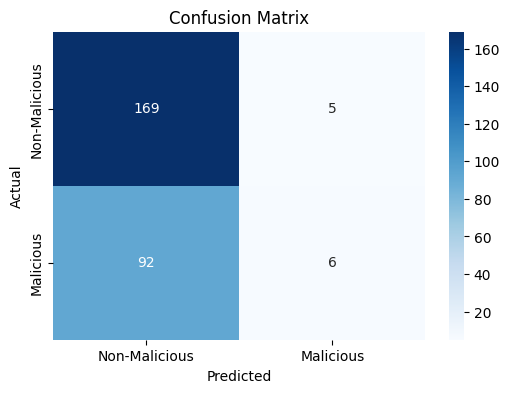

In [9]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Malicious", "Malicious"], yticklabels=["Non-Malicious", "Malicious"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [10]:
X_test

,Tot Fwd Pkts,Tot Bwd Pkts,Flow Duration
2018-02-14 08:28:00,5104,6363,4.504010e+07
2018-02-14 08:29:00,14023,19109,3.526126e+07
2018-02-14 08:30:00,28300,32402,3.725980e+07
2018-02-14 08:31:00,14204,21736,1.690591e+07
2018-02-14 08:32:00,11562,16850,1.104209e+07
...,...,...,...
2018-02-14 12:55:00,6496,7145,2.341351e+07
2018-02-14 12:56:00,3565,2895,9.351564e+06
2018-02-14 12:57:00,2792,2310,9.474821e+06
2018-02-14 12:58:00,4787,5120,1.744751e+07


In [11]:
test_df = all_df[all_df.index > EXCHANGE_RETURN].copy()
test_df['Predicted'] = y_pred

predicted_malicious_times = test_df[test_df['Predicted'] == 1].index
predicted_malicious_times

DatetimeIndex(['2018-02-14 08:52:00', '2018-02-14 08:53:00',
               '2018-02-14 08:54:00', '2018-02-14 08:55:00',
               '2018-02-14 08:57:00', '2018-02-14 10:54:00',
               '2018-02-14 10:58:00', '2018-02-14 10:59:00',
               '2018-02-14 11:10:00', '2018-02-14 11:41:00',
               '2018-02-14 11:48:00'],
              dtype='datetime64[ns]', freq=None)

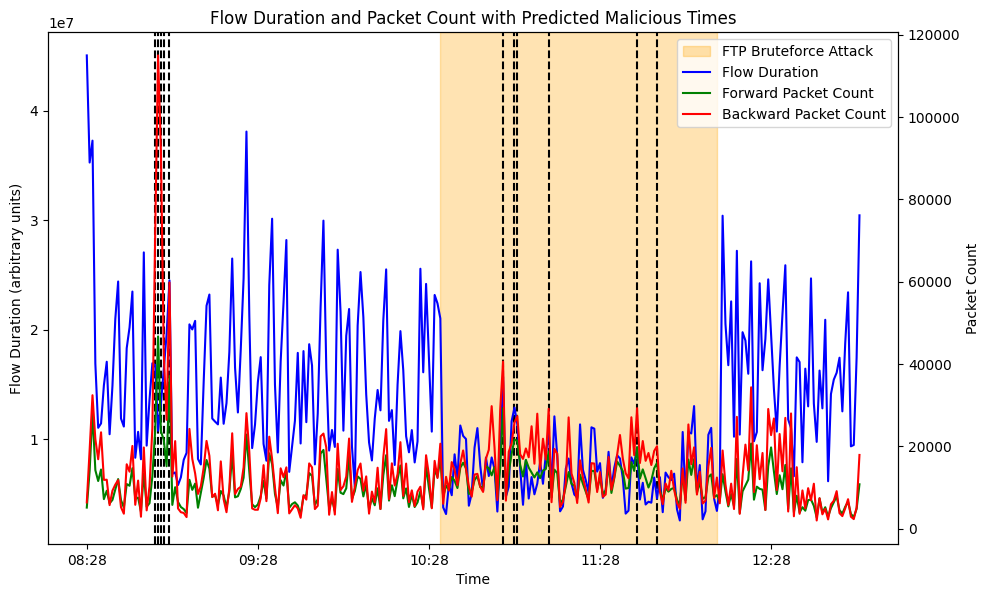

In [20]:
FTP_ATTACK_START = pd.Timestamp('2018-02-14 10:32:00')
FTP_ATTACK_END = pd.Timestamp('2018-02-14 12:09:00')

fig, ax = plt.subplots(figsize=(10, 6))

ax.axvspan(pd.Timestamp(FTP_ATTACK_START), pd.Timestamp(FTP_ATTACK_END), 
        color='orange', alpha=0.3, label="FTP Bruteforce Attack")

for time in predicted_malicious_times:
    ax.axvline(x=time, color='black', linestyle='--', linewidth=1.5, label="Predicted Malicious" if not ax.get_legend_handles_labels()[1] else "")

ax.plot(test_df.index, test_df['Flow Duration'], label='Flow Duration', color='blue')
ax.set_xlabel('Time')
ax.set_ylabel('Flow Duration (arbitrary units)')

ax2 = ax.twinx()
ax2.plot(test_df.index, test_df['Tot Fwd Pkts'], label='Forward Packet Count', color='green')
ax2.plot(test_df.index, test_df['Tot Bwd Pkts'], label='Backward Packet Count', color='red')
ax2.set_ylabel('Packet Count')

fig.tight_layout()

# Reprocess x axis to show every hour
plt.xticks(pd.date_range(start=test_df.index.min(), end=test_df.index.max(), freq='h'))
plt.xticks(rotation=45)

# Reprocess x axis labels to show only hour
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

handles = handles1 + handles2
labels = labels1 + labels2

unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())
ax.set_title('Flow Duration and Packet Count with Predicted Malicious Times')
plt.show()
